In [1]:
# Install MySql packages
# conda update -n base -c conda-forge conda --yes
# !pip install ipython-sql
# !pip install mysql-connector-python
# !conda install -c conda-forge python-dotenv --yes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import mysql.connector
from mysql.connector import Error
from os import environ, path
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype

In [3]:
# Read enviromental variables to connect the database
load_dotenv()
password = environ.get('PASSWORD')
host = environ.get('HOST')
database = environ.get('DATABASE')

In [4]:
# List of colors
colors = ['lime', 'darkorange', 'darkgreen', 'royalblue', 
         'darkred', 'gold', 'teal', 'blueviolet', 'coral', 
         'yellowgreen', 'steelblue', 'crimson', 'tan']

## Connect to the database and create dataframes for each table

In [5]:
try:
    connection = mysql.connector.connect(host=host ,
                                        database=database,
                                        user='root',
                                        password=password)
    if connection.is_connected():
        print("Succes Connected")
    df_musician = pd.read_sql_query("SELECT * FROM music_and_death.musician;", connection)
    df_birth = pd.read_sql_query("SELECT * FROM music_and_death.birth;", connection)
    df_death = pd.read_sql_query("SELECT * FROM music_and_death.death;", connection)
    df_genre = pd.read_sql_query("SELECT * FROM music_and_death.music_genre;", connection)
    genre = pd.read_sql_query("SELECT * FROM music_and_death.genre;", connection)
    cause_death = pd.read_sql_query("SELECT * FROM music_and_death.cause_death;", connection)
    cities = pd.read_sql_query("SELECT * FROM music_and_death.cities;", connection)
    states = pd.read_sql_query("SELECT * FROM music_and_death.states;", connection)
    countries = pd.read_sql_query("SELECT * FROM music_and_death.countries;", connection)
    
    
except Error as e:
    print("Error closing connection")

# Concatenate tables
else:
    # Concatenate musician and death dataframes
    df = pd.concat([df_musician, df_birth], axis=1)
    df = pd.concat([df, df_death], axis=1)
    df = pd.merge(df, cause_death, on=["death_id", "death_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, df_genre, on=["musician_id"])
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df = pd.merge(df, genre, on=["genre_id"])
    # rearrange columns
    df = df.iloc[:, [0, 1, 2, 3, 5, 7, 8, 9, 11, 6, 4, 10]]
    
finally:
    connection.close()

Succes Connected


## Merge and clean the cities, states and countries tables

In [6]:
# merge cities table with states table
place = cities.merge(states, 
                      left_on=cities["state_id"], 
                      right_on=states["id"])

# drop duplicate keys
place.drop(['key_0', 'state_id', 'id_y'], axis=1, inplace=True)

# merge resulted table with countries table
place = place.merge(countries, 
                        left_on=place["country_id"],
                        right_on=countries["id"])

# drop duplicated keys
place.drop(['key_0', 'country_id', 'id', 'iso2', 'capital'], 
              axis=1, 
              inplace=True)

# rename column names
place.rename(
    columns={'name_x': 'City', 
             'name_y': 'State', 
             'name': 'Country', 
             'id_x': 'city_id'},
    inplace=True
)

##  Drop columns with not use

In [7]:
df.drop(['middle_name', 'death_id', "death_date", "genre_id", "birth"], 
        axis=1, 
        inplace=True)

In [8]:
df

,musician_id,stage_name,stage_lastname,death_age,cause,genre,birthplace_id
0,1,John,Lennon,40,homicide,rock,50337
1,432,Kit,Lambert,45,homicide,rock,50388
2,459,Rusty,Day,36,homicide,rock,117057
3,481,Felix,Pappalardi,43,homicide,rock,122795
4,559,Tommy,Blake,54,homicide,rock,114990
...,...,...,...,...,...,...,...
816,516,Meredith,Willson,82,heart disease,classical,121375
817,478,William,Walton,80,natural causes,classical,50807
818,703,Irving,Berlin,101,natural causes,classical,102005
819,185,Nelson,Eddy,65,brain related,classical,124716


In [9]:
place

,city_id,City,State,Country
0,52,Ashkāsham,Badakhshan,Afghanistan
1,68,Fayzabad,Badakhshan,Afghanistan
2,78,Jurm,Badakhshan,Afghanistan
3,84,Khandūd,Badakhshan,Afghanistan
4,115,Rāghistān,Badakhshan,Afghanistan
...,...,...,...,...
148261,131496,Redcliff,Midlands Province,Zimbabwe
148262,131502,Shangani,Midlands Province,Zimbabwe
148263,131503,Shurugwi,Midlands Province,Zimbabwe
148264,131504,Shurugwi District,Midlands Province,Zimbabwe


## Merge musician info dataframe with place dataframe

In [10]:
# merge df and place dataframes
musician = df.merge(place, 
                    left_on=df['birthplace_id'], 
                    right_on=place['city_id'])

# drop unused columns
musician.drop(['birthplace_id', 'city_id', 'key_0'], axis=1, inplace=True)

In [11]:
musician

,musician_id,stage_name,stage_lastname,death_age,cause,genre,City,State,Country
0,1,John,Lennon,40,homicide,rock,Liverpool,England,United Kingdom
1,271,Rory,Storm,34,suicide,rock,Liverpool,England,United Kingdom
2,502,Tom,Evans,36,suicide,rock,Liverpool,England,United Kingdom
3,473,Billy,Fury,42,heart disease,rock,Liverpool,England,United Kingdom
4,188,Brian,Epstein,32,drugs related,rock,Liverpool,England,United Kingdom
...,...,...,...,...,...,...,...,...,...
815,516,Meredith,Willson,82,heart disease,classical,Mason City,Iowa,United States
816,478,William,Walton,80,natural causes,classical,Oldham,England,United Kingdom
817,703,Irving,Berlin,101,natural causes,classical,Tyumen,Tyumen Oblast,Russia
818,185,Nelson,Eddy,65,brain related,classical,Providence,Rhode Island,United States


In [12]:
musician.to_csv('musicians.csv')

## Create plots to observe the data

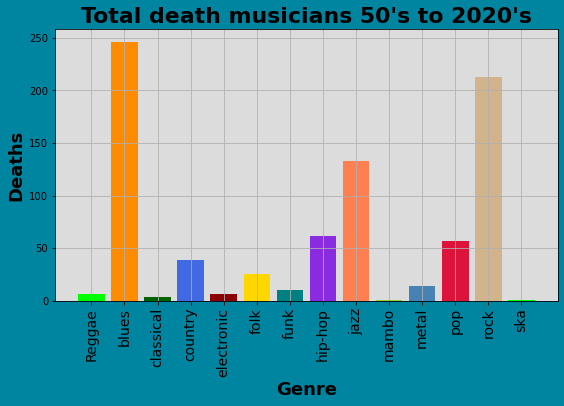

In [13]:
# Bar plot to show deaths per music genre 

# Create a new music table using genre as indez and size of each genre
df_n = musician.pivot_table(index=['genre'], aggfunc='size')

# plot the data
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor("gainsboro")
ax.set_title("Total death musicians 50's to 2020's",
             size=22,
             fontweight="bold" )
plt.bar(df_n.index, df_n, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.grid()
plt.show()

## Cause of death per music genre

In [14]:
df_cd = musician.pivot_table(index=['cause', 'genre'], aggfunc='size')
df_cd

cause      genre     
 accident  hip-hop        1
           rock           2
AIDS       blues          1
           electronic     1
           funk           2
                         ..
unknown    folk           3
           funk           1
           jazz          17
           pop            5
           rock           5
Length: 119, dtype: int64

# Questions

## Most common Death Ages


In [15]:
n_da = musician['death_age'].value_counts().nlargest(10)

In [16]:
n_da

27    33
32    29
37    21
36    21
28    21
49    18
45    18
24    18
42    17
39    17
Name: death_age, dtype: int64

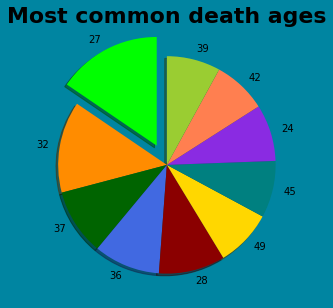

In [17]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_title("Most common death ages",
             size=22,
             fontweight="bold" )
plt.pie(n_da.values, labels=n_da.index, 
        colors=colors,
        startangle=90,
        shadow=True,
        explode = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
plt.show()

## Most common Music Genre deaths

In [18]:
n_mg = musician['genre'].value_counts()

In [19]:
n_mg

blues         246
rock          213
jazz          133
hip-hop        62
pop            57
country        39
folk           26
metal          14
funk           10
electronic      7
Reggae          7
classical       4
mambo           1
ska             1
Name: genre, dtype: int64

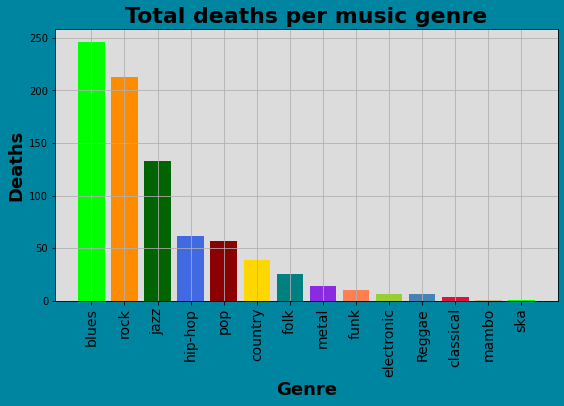

In [20]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Total deaths per music genre",
             size=22,
             fontweight="bold" )
plt.bar(n_mg.index, n_mg.values, color=colors)
plt.ylabel("Deaths", size=18, fontweight="bold")
plt.xlabel("Genre", size=18, fontweight="bold")
plt.xticks(rotation='vertical', size=14)
plt.grid()
plt.show()

# Places

### Most common countries of origin of dead musicians

In [21]:
n_places = musician['Country'].value_counts().nlargest(10)

In [22]:
n_places

United States     650
United Kingdom     82
Canada             10
Germany             9
Jamaica             9
Australia           7
Russia              6
South Africa        4
France              3
Poland              3
Name: Country, dtype: int64

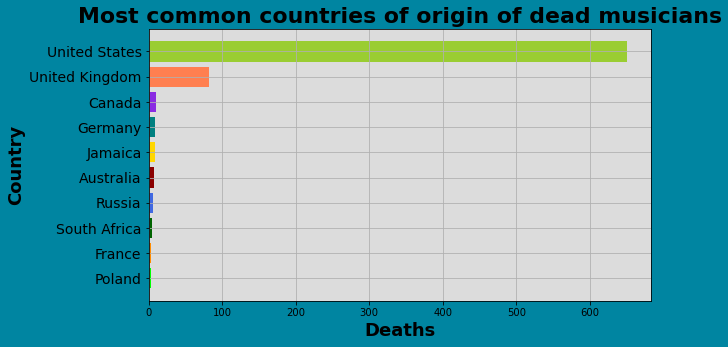

In [23]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common countries of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_places.iloc[::-1].index, n_places.iloc[::-1].values, color=colors)
plt.ylabel("Country", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

### Most common States of origin of dead musicians

In [24]:
n_states = musician['State'].value_counts().nlargest(10)

In [25]:
n_states

New York        71
England         69
Mississippi     65
California      50
Texas           49
Louisiana       41
Tennessee       38
Pennsylvania    31
Illinois        29
Alabama         24
Name: State, dtype: int64

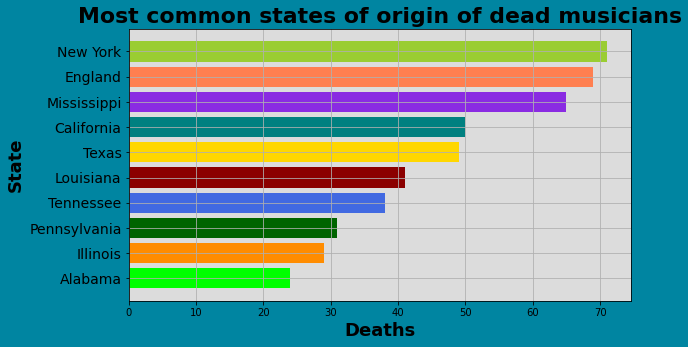

In [26]:
plt.figure(figsize=(9,5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common states of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_states.iloc[::-1].index, n_states.iloc[::-1].values, color=colors)
plt.ylabel("State", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

### Most common Cities

In [27]:
n_cities = musician['City'].value_counts().nlargest(10)

In [28]:
n_cities

New York City    37
London           29
Chicago          25
Philadelphia     20
Los Angeles      19
Memphis          17
New Orleans      17
Birmingham       13
Detroit           9
Dallas            8
Name: City, dtype: int64

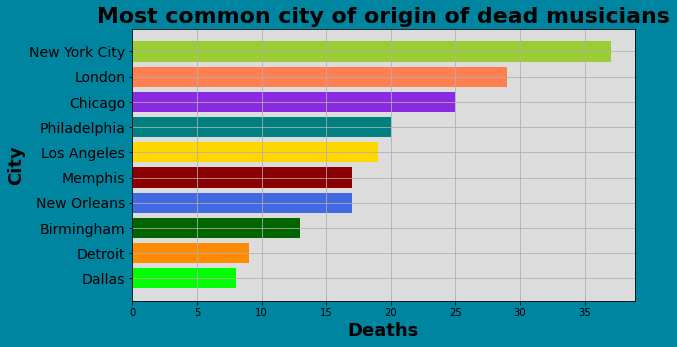

In [29]:
plt.figure(figsize=(9, 5), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common city of origin of dead musicians",
            size=22,
            fontweight="bold")
plt.barh(n_cities.iloc[::-1].index, n_cities.iloc[::-1].values, color=colors)
plt.ylabel("City", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

## Death genre - cause

In [30]:
n_cd_gr = musician.loc[:, ['genre', 'cause']].value_counts()

In [31]:
n_cd_gr.head(10)

genre    cause                  
blues    heart disease              68
hip-hop  homicide                   58
blues    unknown                    48
         cancer                     37
jazz     heart disease              36
         cancer                     35
rock     heart disease              35
         drugs related              32
         suicide                    24
         car/motorcycle accident    22
dtype: int64

In [32]:
n_cd_gr = n_cd_gr.reset_index()
n_cd_gr.rename(columns={0: 'deaths'}, inplace=True)

In [33]:
n_cd_gr

,genre,cause,deaths
0,blues,heart disease,68
1,hip-hop,homicide,58
2,blues,unknown,48
3,blues,cancer,37
4,jazz,heart disease,36
...,...,...,...
114,jazz,suicide,1
115,jazz,surgery,1
116,jazz,tuberculosis,1
117,mambo,heart disease,1


### Blues 

In [34]:
n_blues = n_cd_gr.loc[n_cd_gr['genre'] == 'blues', ]

In [35]:
n_blues

,genre,cause,deaths
0,blues,heart disease,68
2,blues,unknown,48
3,blues,cancer,37
14,blues,homicide,14
15,blues,respiratory disease,13
20,blues,diabetes,10
23,blues,drugs related,9
25,blues,car/motorcycle accident,8
26,blues,brain related,8
29,blues,natural causes,6


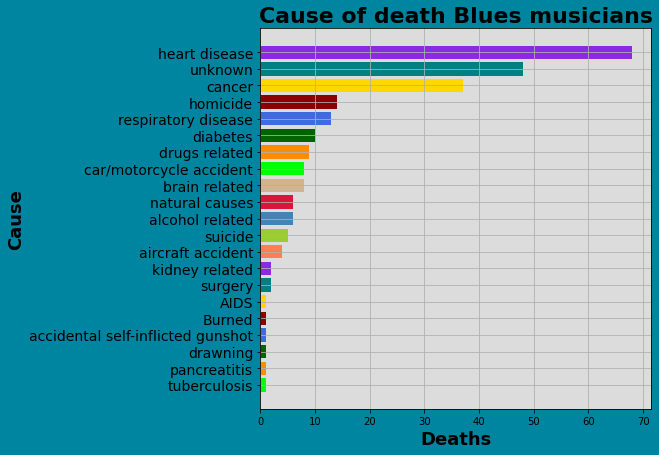

In [36]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Cause of death Blues musicians",
            size=22,
            fontweight="bold")
plt.barh(n_blues['cause'].iloc[::-1],
         n_blues['deaths'].iloc[::-1],
         color=colors)
plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()


### Rock

In [37]:
n_rock = n_cd_gr.loc[n_cd_gr['genre'] == 'rock', ]

In [38]:
n_rock

,genre,cause,deaths
6,rock,heart disease,35
7,rock,drugs related,32
8,rock,suicide,24
9,rock,car/motorcycle accident,22
10,rock,cancer,21
12,rock,alcohol related,16
18,rock,brain related,11
19,rock,aircraft accident,10
21,rock,drawning,9
22,rock,respiratory disease,9


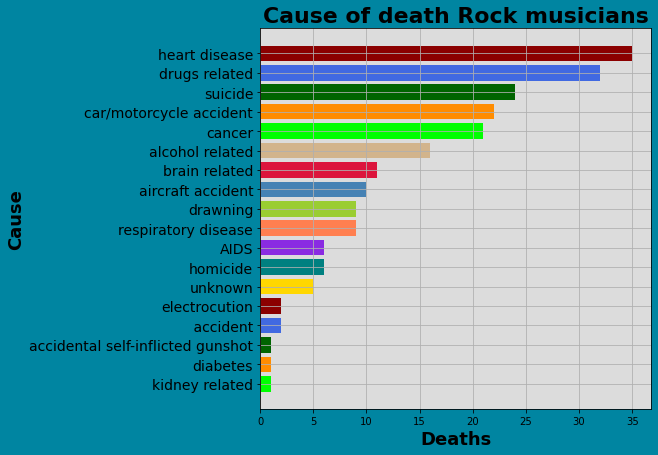

In [39]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Cause of death Rock musicians",
            size=22,
            fontweight="bold")
plt.barh(n_rock['cause'].iloc[::-1],
         n_rock['deaths'].iloc[::-1],
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()


### Jazz

In [40]:
n_jazz = n_cd_gr.loc[n_cd_gr['genre'] == 'jazz', ]

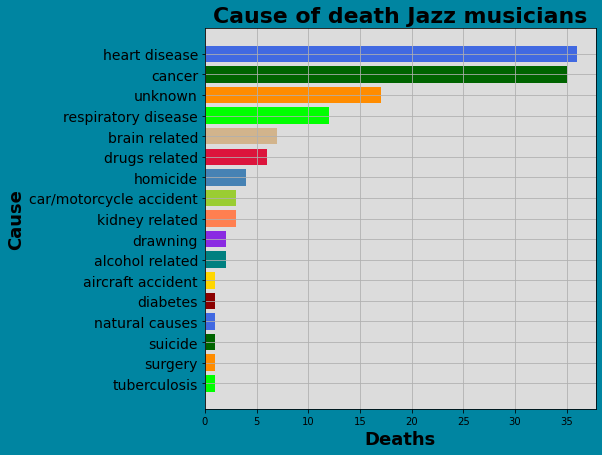

In [41]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Cause of death Jazz musicians",
            size=22,
            fontweight="bold")
plt.barh(n_jazz['cause'].iloc[::-1],
         n_jazz['deaths'].iloc[::-1],
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()

## Most common Cause o deaths

In [42]:
n_cause_death = musician['cause'].value_counts().nlargest(10)

In [43]:
n_cause_death

heart disease              173
cancer                     119
homicide                    92
unknown                     85
drugs related               64
car/motorcycle accident     49
respiratory disease         43
suicide                     40
aircraft accident           30
brain related               28
Name: cause, dtype: int64

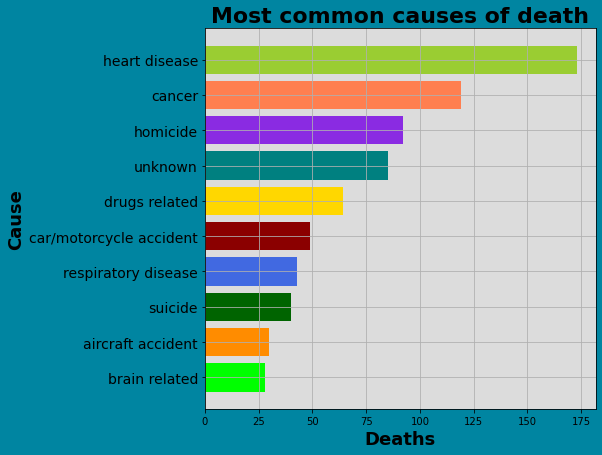

In [44]:
plt.figure(figsize=(7,7), facecolor='#0085a1')
ax = plt.axes()
ax.set_facecolor('gainsboro')
ax.set_title("Most common causes of death",
            size=22,
            fontweight="bold")
plt.barh(n_cause_death.iloc[::-1].index,
         n_cause_death.iloc[::-1].values,
         color=colors)

plt.ylabel("Cause", size=18, fontweight="bold")
plt.xlabel("Deaths", size=18, fontweight="bold")
plt.yticks(size=14)
plt.grid()
plt.show()
